In [1]:
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import numpy

In [3]:
from result.ldc_2d_benchmark_P100  import ldc_2d_p100
from result.ldc_2d_benchmark_K2200 import ldc_2d_k2200
from result.ldc_3d_benchmark_P100  import ldc_3d_p100
from result.ldc_3d_benchmark_K2200 import ldc_3d_k2200

In [4]:
ldc_2d_k2200[0]

((32, (16, 1), 'single', True), [15, 16, 16, 16, 16, 16, 16, 16, 16, 16])

In [5]:
ldc_3d_k2200[0]

((16, (16, 1, 1), 'symbolic.D3Q19', 'single', True),
 [58, 60, 60, 60, 60, 60, 60, 60, 59, 60])

In [6]:
def descriptor_subset(data, descriptor):
    return list(
        map(lambda m: (m[0][0:2] + m[0][3:], m[1]),
            filter(lambda m: m[0][2] == descriptor, ldc_3d_p100)))

In [7]:
ldc_3d_D3Q19_p100  = descriptor_subset(ldc_3d_p100,  'symbolic.D3Q19')
ldc_3d_D3Q27_p100  = descriptor_subset(ldc_3d_p100,  'symbolic.D3Q27')
ldc_3d_D3Q19_k2200 = descriptor_subset(ldc_3d_k2200, 'symbolic.D3Q19')
ldc_3d_D3Q27_k2200 = descriptor_subset(ldc_3d_k2200, 'symbolic.D3Q27')

In [8]:
def values(data, index):
    return set(map(lambda m: m[0][index], data))

In [9]:
values(ldc_3d_D3Q19_k2200, 0)

{16, 32, 48, 64, 96, 128}

In [10]:
def has(value, options):
    if options == None:
        return True
    else:
        return value in options

def subset(data, size=None, layout=None, precision=None, optimization=None):
    return list(
        filter(lambda m: has(m[0][0], size) and has(m[0][1][0], layout) and has(m[0][2], precision) and has(m[0][3], optimization),
               data))

In [11]:
def mlups_for_size(measurement):
    dim = len(list(measurement[0][1]))
    return (measurement[0][0]**dim, numpy.average(measurement[1]))

In [12]:
def scatter(data, **kwargs):
    plt.scatter(*zip(*list(data)), **kwargs)

In [13]:
def mlups_per_size_overview_plot(data, title, **kwargs):
    plt.figure(figsize=(10,8))
    plt.grid()
    plt.title(title)
    plt.xscale('log')
    plt.xlabel('Cells')
    plt.ylabel('MLUPS')
    scatter(map(mlups_for_size, subset(data, precision=['single'], optimization=[True], **kwargs)), label='single, CSE')
    scatter(map(mlups_for_size, subset(data, precision=['double'], optimization=[True], **kwargs)), label='double, CSE')
    scatter(map(mlups_for_size, subset(data, precision=['single'], optimization=[False], **kwargs)), label='single, not-CSE')
    scatter(map(mlups_for_size, subset(data, precision=['double'], optimization=[False], **kwargs)), label='double, not-CSE')
    plt.legend()

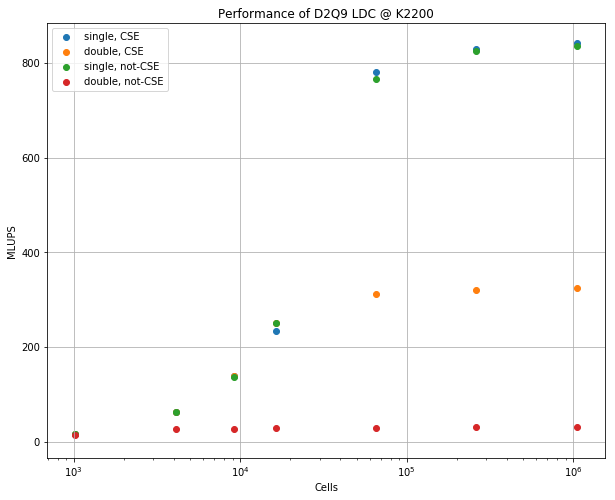

In [14]:
mlups_per_size_overview_plot(ldc_2d_k2200, 'Performance of D2Q9 LDC @ K2200', layout=[32])

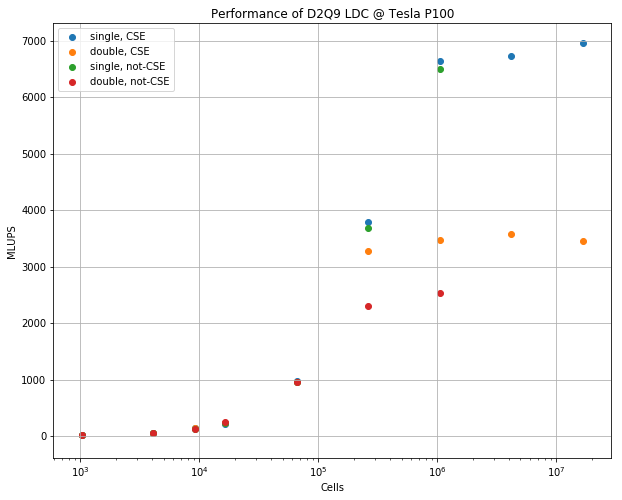

In [15]:
mlups_per_size_overview_plot(ldc_2d_p100, 'Performance of D2Q9 LDC @ Tesla P100', layout=[32])

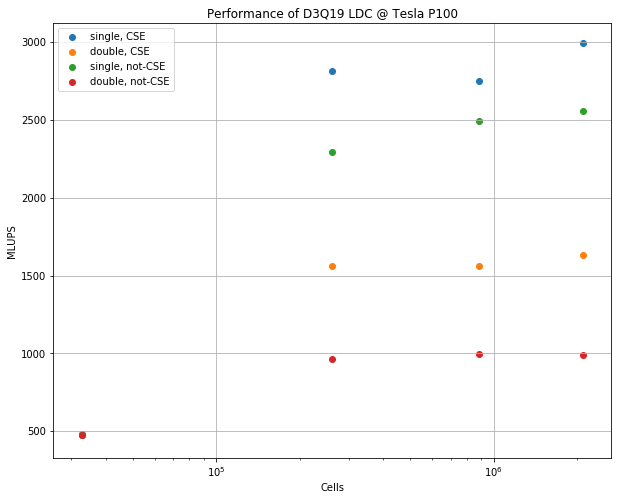

In [16]:
mlups_per_size_overview_plot(ldc_3d_D3Q19_p100, 'Performance of D3Q19 LDC @ Tesla P100', layout=[32])

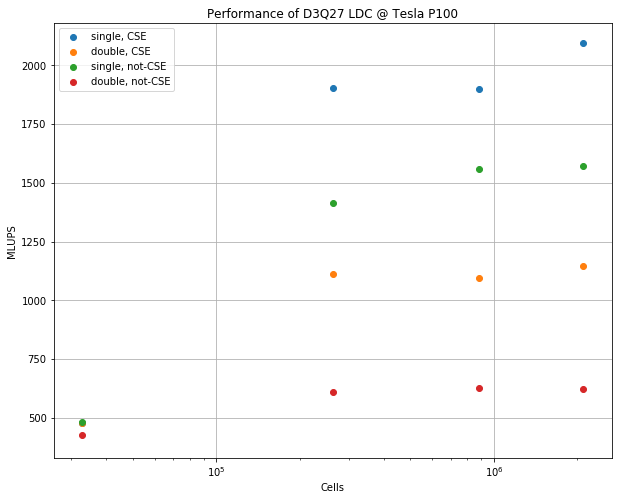

In [17]:
mlups_per_size_overview_plot(ldc_3d_D3Q27_p100, 'Performance of D3Q27 LDC @ Tesla P100', layout=[32])

In [18]:
def mlups_for_layout(measurement):
    return (measurement[0][1][0], numpy.average(measurement[1]))

In [19]:
def mlups_per_layout_overview_plot(data, title, **kwargs):
    plt.figure(figsize=(10,8))
    plt.grid()
    plt.title(title)
    plt.xscale('log')
    plt.xlabel('Thread block size')
    plt.ylabel('MLUPS')
    plt.xticks(list(map(lambda l: l[0], values(subset(data, **kwargs),1))), values(subset(data, **kwargs),1))
    scatter(map(mlups_for_layout, subset(data, precision=['single'], optimization=[True], **kwargs)), label='single, CSE')
    scatter(map(mlups_for_layout, subset(data, precision=['double'], optimization=[True], **kwargs)), label='double, CSE')
    scatter(map(mlups_for_layout, subset(data, precision=['single'], optimization=[False], **kwargs)), label='single, not-CSE')
    scatter(map(mlups_for_layout, subset(data, precision=['double'], optimization=[False], **kwargs)), label='double, not-CSE')
    plt.legend()

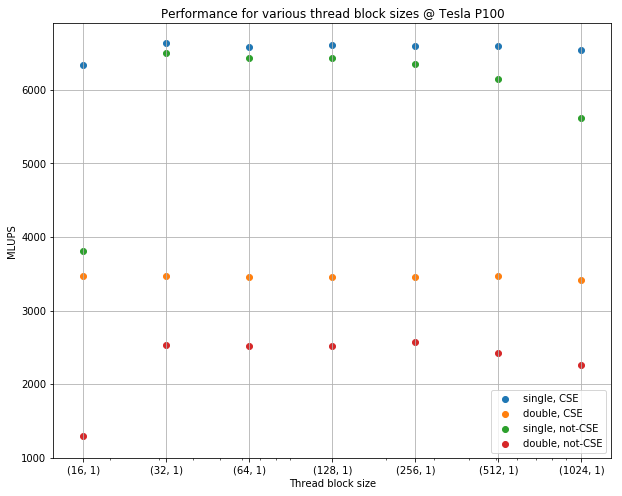

In [20]:
mlups_per_layout_overview_plot(ldc_2d_p100, 'Performance for various thread block sizes @ Tesla P100', size=[1024])

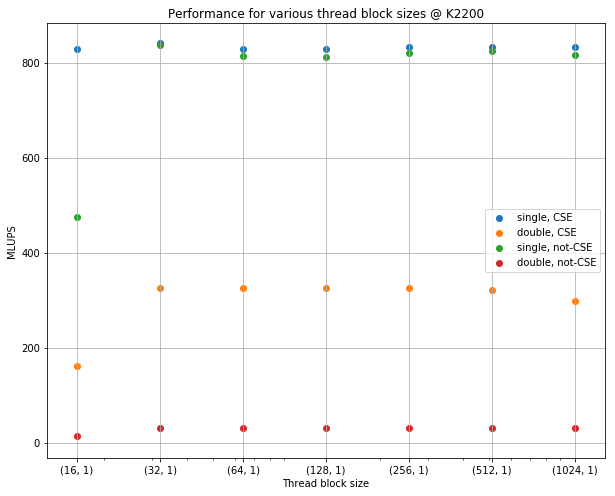

In [21]:
mlups_per_layout_overview_plot(ldc_2d_k2200, 'Performance for various thread block sizes @ K2200', size=[1024])

In [22]:
def mlups_spread(data, **kwargs):
    tmp = list(map(lambda m: numpy.average(m[1]), subset(data, **kwargs)))
    return (numpy.amin(tmp), numpy.amax(tmp))

In [23]:
mlups_spread(ldc_2d_p100, precision=['single'])

(14.2, 6963.3)

In [24]:
mlups_spread(ldc_2d_p100, size=[1024], precision=['single'])

(3809.8, 6641.6)

In [25]:
def spreads(data, sizes, **kwargs):
    return list(map(lambda s: mlups_spread(data, size=[s], **kwargs), sizes))

In [26]:
spreads(ldc_2d_p100, [32,64,96,128,512,1024])

[(14.2, 15.0),
 (56.6, 60.2),
 (126.2, 136.7),
 (204.2, 242.6),
 (1233.3, 3889.3),
 (1291.9, 6641.6)]

In [27]:
def get_dim(data):
    layouts = values(data, 1)
    return len(list(layouts)[0])

In [28]:
def mlups_per_cell_spread_plot(data, title, **kwargs):
    dim = get_dim(data)
    widths = values(data, 0)
    sizes = list(map(lambda x: x**dim, widths))
    lines = list(zip(*spreads(data, widths, **kwargs)))
    plt.figure(figsize=(10,8))
    plt.grid()
    plt.title(title)
    plt.xscale('log')
    plt.xlabel('Cells')
    plt.ylabel('MLUPS')
    plt.vlines(sizes, ymin=lines[0], ymax=lines[1])
    plt.scatter(sizes, lines[0], marker='o', c='black')
    plt.scatter(sizes, lines[1], marker='o', c='black')

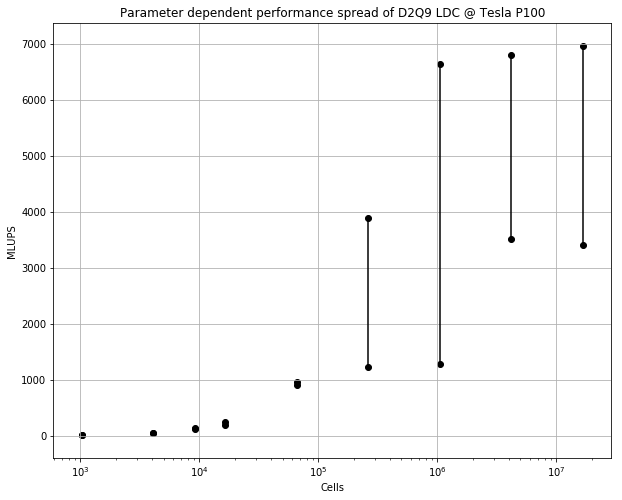

In [29]:
mlups_per_cell_spread_plot(ldc_2d_p100, 'Parameter dependent performance spread of D2Q9 LDC @ Tesla P100')

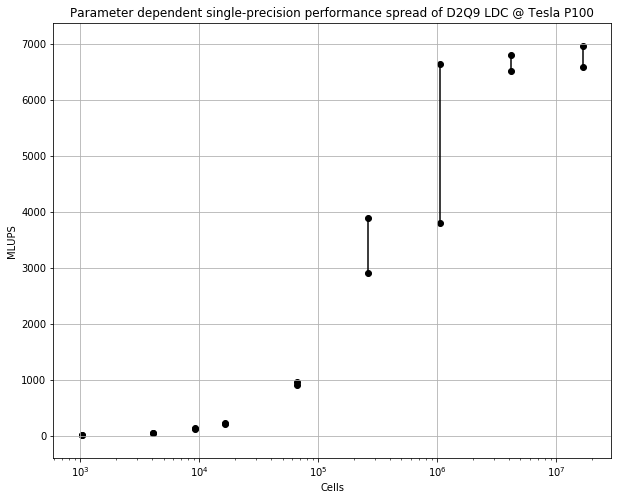

In [30]:
mlups_per_cell_spread_plot(
    ldc_2d_p100,
    'Parameter dependent single-precision performance spread of D2Q9 LDC @ Tesla P100',
    precision=['single'])

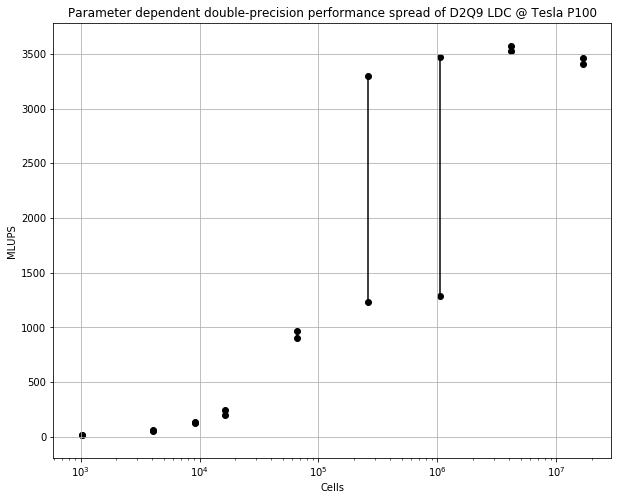

In [31]:
mlups_per_cell_spread_plot(
    ldc_2d_p100,
    'Parameter dependent double-precision performance spread of D2Q9 LDC @ Tesla P100',
    precision=['double'])

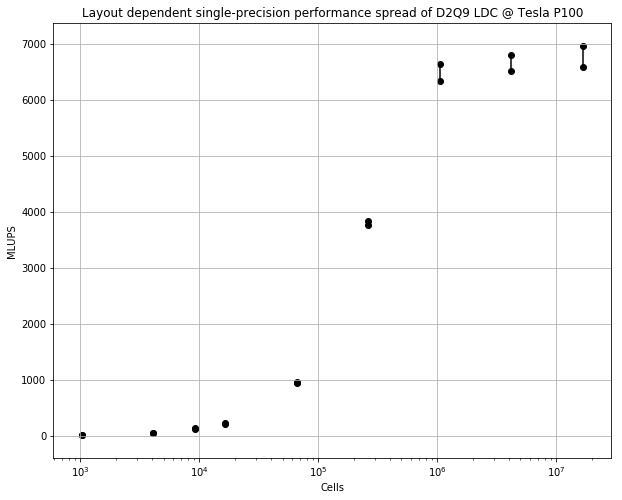

In [32]:
mlups_per_cell_spread_plot(
    ldc_2d_p100,
    'Layout dependent single-precision performance spread of D2Q9 LDC @ Tesla P100',
    precision=['single'], optimization=[True])

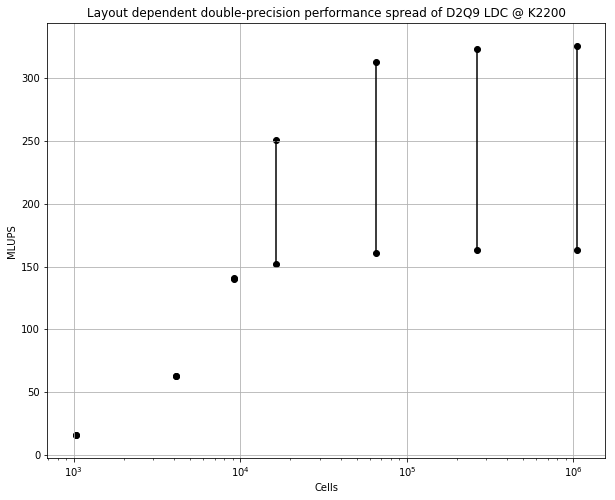

In [33]:
mlups_per_cell_spread_plot(
    ldc_2d_k2200,
    'Layout dependent double-precision performance spread of D2Q9 LDC @ K2200',
    precision=['double'], optimization=[True])

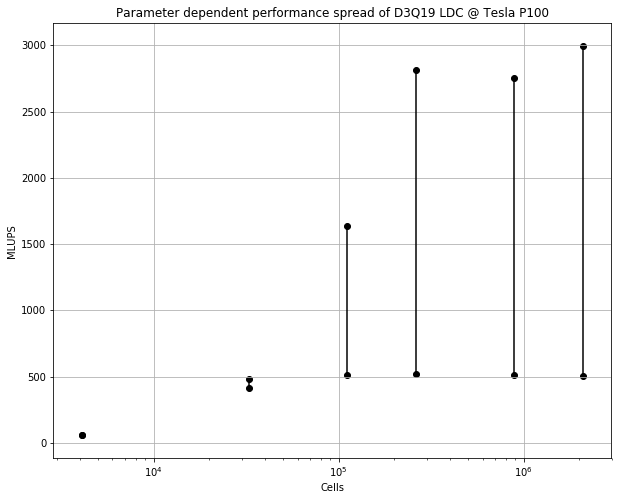

In [34]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q19_p100,
    'Parameter dependent performance spread of D3Q19 LDC @ Tesla P100')

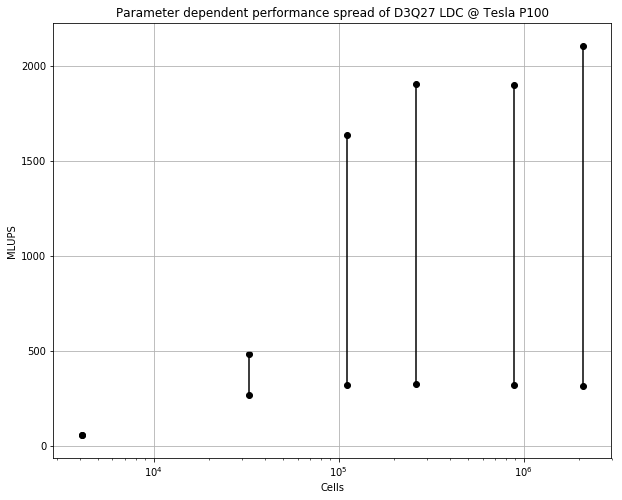

In [35]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q27_p100,
    'Parameter dependent performance spread of D3Q27 LDC @ Tesla P100')

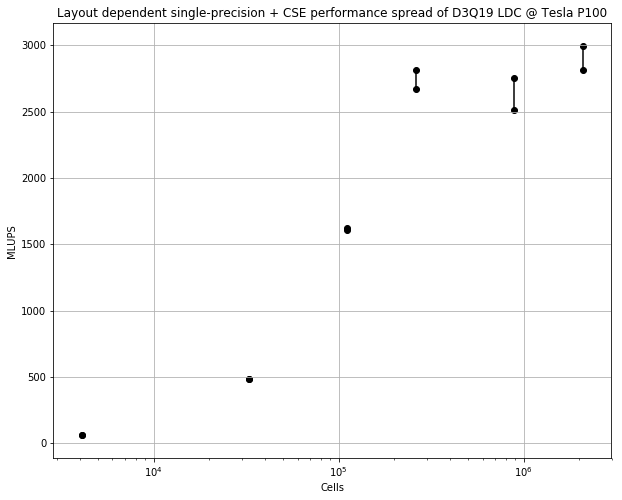

In [36]:
mlups_per_cell_spread_plot(
    ldc_3d_D3Q19_p100,
    'Layout dependent single-precision + CSE performance spread of D3Q19 LDC @ Tesla P100',
    precision=['single'], optimization=[True])